# Importing Dataset

In [1]:
# prompt: extract .rar file from google drive

!pip install unrar

# from google.colab import drive
# drive.mount('/content/drive')

!unrar x "/content/drive/MyDrive/Foto Terklasifikasi.rar" "/content/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Foto Terklasifikasi.rar

Creating    /content/Foto Terklasifikasi                              OK
Creating    /content/Foto Terklasifikasi/ER                           OK
Extracting  /content/Foto Terklasifikasi/ER/1. ER 100x negatif.jpg         0%  OK 
Extracting  /content/Foto Terklasifikasi/ER/1. ER 400x negatif.jpg         0%  OK 
Extracting  /content/Foto Terklasifikasi/ER/1. ER 40x negatif.jpg          0%  OK 
Extracting  /content/Foto Terklasifikasi/ER/10. ER 100x negatif.jpg        0%  OK 
Extracting  /content/Foto Terklasifikasi/ER/10. ER 400x negatif.jpg        0%  OK 
Extracting  /content/Foto Terklasifikasi/ER/10. ER 40x negatif.jpg         0%  1%  OK 
Extracting  /content/Foto Terklasifikasi/ER/11. ER 100x negatif.jpg        1%  OK 
Extracting  /content/Foto Terklasifikasi/ER/11. ER 400x negati

# 1. Canny Edge Detection

## Parameters
Gaussian Blur Parameter:
1. **kernel_size:** A larger kernel size will blur the image more, potentially reducing noise but also possibly removing some edge details. Try different odd values like (5,5), (7,7), (9,9), etc.

Canny Edge Detection Thresholds
2. **low_threshold:** Lower values will allow more edges to be detected (potentially including noise).
3. **high_threshold:** Higher values will result in fewer edges being detected (more likely to miss weaker edges).

Dilation Iterations and Kernel Size
4. **morph_shape:** shape of the kernel
5. **kernel_size:** The size of the structuring element. You can use different shapes like cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), cv2.MORPH_ELLIPSE, etc.
6. **num_iterations:** More iterations will increase the thickness of edges, potentially merging separate edges.

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# function: canny_count(img_path: str)
# Given a path to an image, count the amount of cell nuclei using canny edge detection
def canny_count(img_path, blur_kernel_size=(11,11), low_threshold=30, high_threshold=105, morph_shape=cv2.MORPH_RECT, dilation_kernel_size=(1, 1), dilation_iterations=2, show_img=False):
  image = cv2.imread(img_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # Conversion of image Into Gray Color
  # Apply Otsu's thresholding
  _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  blur = cv2.GaussianBlur(binary, blur_kernel_size, 0)    # Add Gaussian Blur
  canny = cv2.Canny(blur, low_threshold, high_threshold, 3)    # Using Canny Edge Detection Algorithm
  dilated = cv2.dilate(canny, cv2.getStructuringElement(morph_shape, dilation_kernel_size), iterations=dilation_iterations)    # Dilation is used to observe changes
  (cnt, heirarchy ) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  cv2.drawContours(rgb, cnt, -1, (0,255,0), 2)

  if show_img:
    # Plot all images in subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(gray, cmap='gray')
    axs[0, 1].set_title('Gray Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(blur, cmap='gray')
    axs[0, 2].set_title('Blurred Image')
    axs[0, 2].axis('off')

    axs[1, 0].imshow(canny, cmap='gray')
    axs[1, 0].set_title('Canny Edge Detection')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(dilated, cmap='gray')
    axs[1, 1].set_title('Dilated Image')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(rgb)
    axs[1, 2].set_title('Contours')
    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()


  return len(cnt)

Processing /content/Foto Terklasifikasi/ER/Berdasarkan Pembesaran/400/15. ER 400x positif.jpg


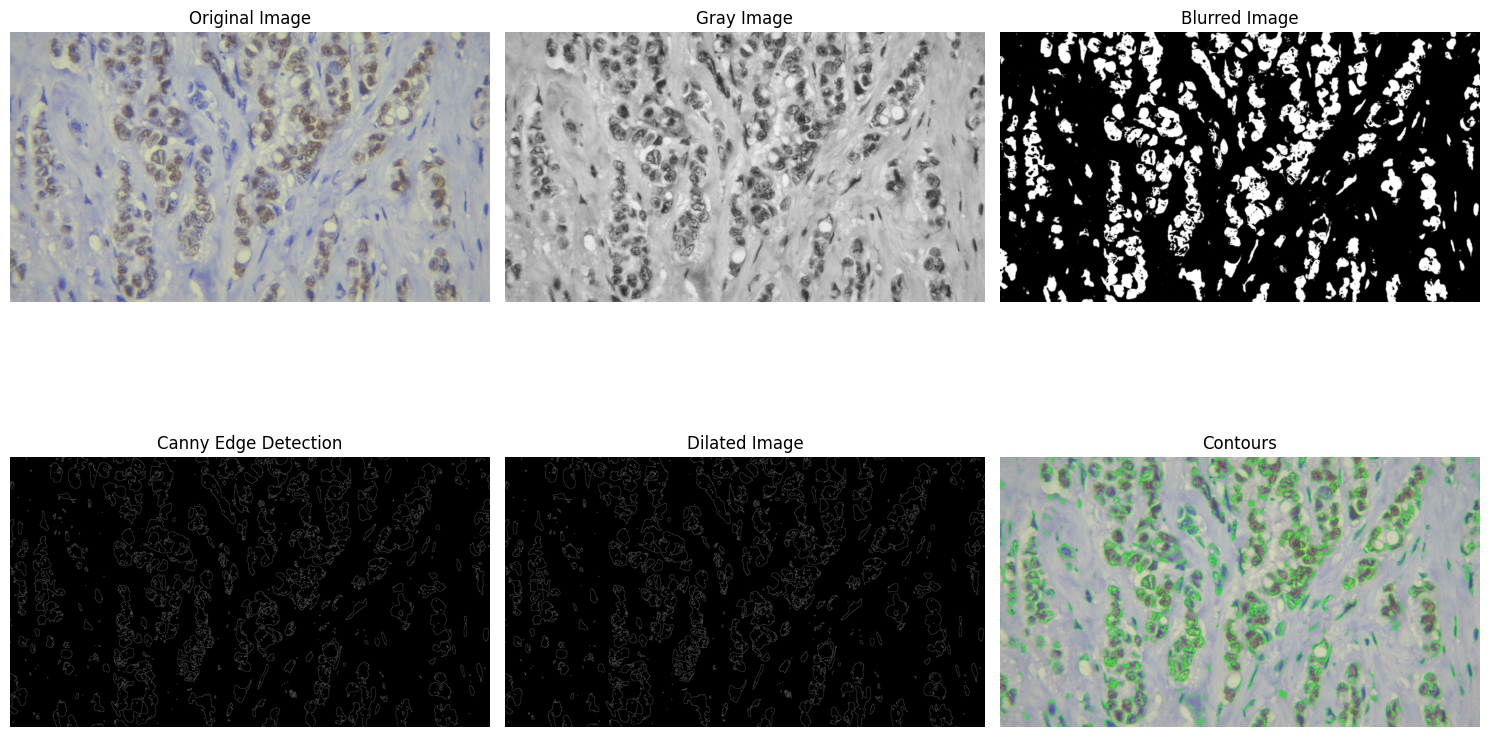

Number of contours: 3777


In [46]:
import os

blur_kernel_size=(11,11)
low_threshold=30
high_threshold=105
morph_shape=cv2.MORPH_RECT
dilation_kernel_size=(1, 1)
dilation_iterations=2

def canny_iterator(path, number_of_samples):
  iteration = 0
  for filename in os.listdir(img_path):
    if filename.endswith('.jpg') and (iteration<number_of_samples):
        file_path = os.path.join(img_path, filename)
        print(f"Processing {file_path}")
        count = canny_count(file_path, blur_kernel_size, low_threshold, high_threshold, morph_shape, dilation_kernel_size, dilation_iterations, True)
        print(f"Number of contours: {count}")
        iteration += 1

img_path = "/content/Foto Terklasifikasi/ER/Berdasarkan Pembesaran/400/"
canny_iterator(img_path, 1)

# 2. Hough Circle Detection

## Parameters
1. **dp (Inverse Ratio of the Accumulator Resolution to the Image Resolution):** This parameter affects the resolution of the accumulator used in the Hough Circle Transform. It determines the ratio between the image resolution and the accumulator resolution. A value of dp=1 means the accumulator has the same resolution as the input image. Increasing dp reduces the accumulator resolution, which can help in detecting larger circles but may miss smaller ones. A value greater than 1.0 (e.g., 1.2 or 1.5) is typically used for better detection in noisy images.

Typical Range: 1.0 to 2.0
2. **min_dist (Minimum Distance Between Detected Centers):** This parameter specifies the minimum distance between the centers of detected circles. It helps to avoid multiple detections of the same circle. A smaller value allows detection of circles that are closer together but may lead to false positives. A larger value ensures that only distinct circles are detected but may miss closely packed nuclei.

Typical Range: Set according to the expected size of the nuclei and their spacing. For histopathology images, this might be 20-50 pixels.
3. **param1 (Higher Threshold for Canny Edge Detector):** This parameter is used in the Canny edge detector step of the Hough Circle Transform. It is the higher threshold for edge detection, where edges with gradient values higher than this threshold are considered strong edges. Higher values may reduce the number of detected edges, leading to fewer circles detected. Lower values may increase false detections. Tuning this parameter helps balance between detecting true circles and reducing noise.

Typical Range: 50-100, depending on the image's edge contrast.
4. **param2 (Accumulator Threshold for Circle Centers):** This parameter is the threshold for the accumulator, used to determine if a circle is detected. It represents the threshold for the center of the circles, meaning that a circle is detected only if the accumulator value for its center exceeds this threshold. Lower values increase the likelihood of detecting circles (potentially more false positives), while higher values reduce the number of detected circles (potentially missing some true circles).

Typical Range: 30-50. This value might need to be adjusted based on the number of circles you expect and the image quality.
5. **min_radius (Minimum Circle Radius):** Specifies the minimum radius of circles to detect. Set this parameter based on the approximate size of the nuclei. Too small a radius might detect noise or irrelevant small circles, while too large a radius might miss small nuclei.

Typical Range: Set according to the expected size of the nuclei. For histopathology images, this might range from 5 to 50 pixels.
6. **max_radius (Maximum Circle Radius):** Specifies the maximum radius of circles to detect. Useful for excluding circles that are too large or too small to be considered as nuclei. Helps to limit detection to the size range of expected nuclei.

Typical Range: Set according to the expected size range of the nuclei. For histopathology images, this might range from 10 to 100 pixels.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

def hough_circle_count(img_path, blur_kernel_size=(11,11), dp=1.2, min_dist=20, param1=50, param2=30, min_radius=0, max_radius=0, show_img=False):
  image = cv2.imread(img_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, blur_kernel_size, 2)
  circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp, min_dist, param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

  # Check if circles were found
  if circles is not None:
    # Convert the circle parameters (x, y, r) to integers
    circles = np.round(circles[0, :]).astype("int")

    # Draw the circles on the original image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for (x, y, r) in circles:
      cv2.circle(rgb_image, (x, y), r, (0, 255, 0), 4)  # Draw the outer circle
      cv2.circle(rgb_image, (x, y), 2, (0, 0, 255), 3)  # Draw the center of the circle

    circle_count = len(circles)
  else:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    circle_count = 0

  # Plot all images in subplots
  if show_img:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(gray, cmap='gray')
    axs[0, 1].set_title('Gray Image')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(blur, cmap='gray')
    axs[1, 0].set_title('Blurred Image')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(rgb_image)
    axs[1, 1].set_title('Circle Contours')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

  return circle_count

Processing /content/Foto Terklasifikasi/ER/Berdasarkan Pembesaran/400/15. ER 400x positif.jpg


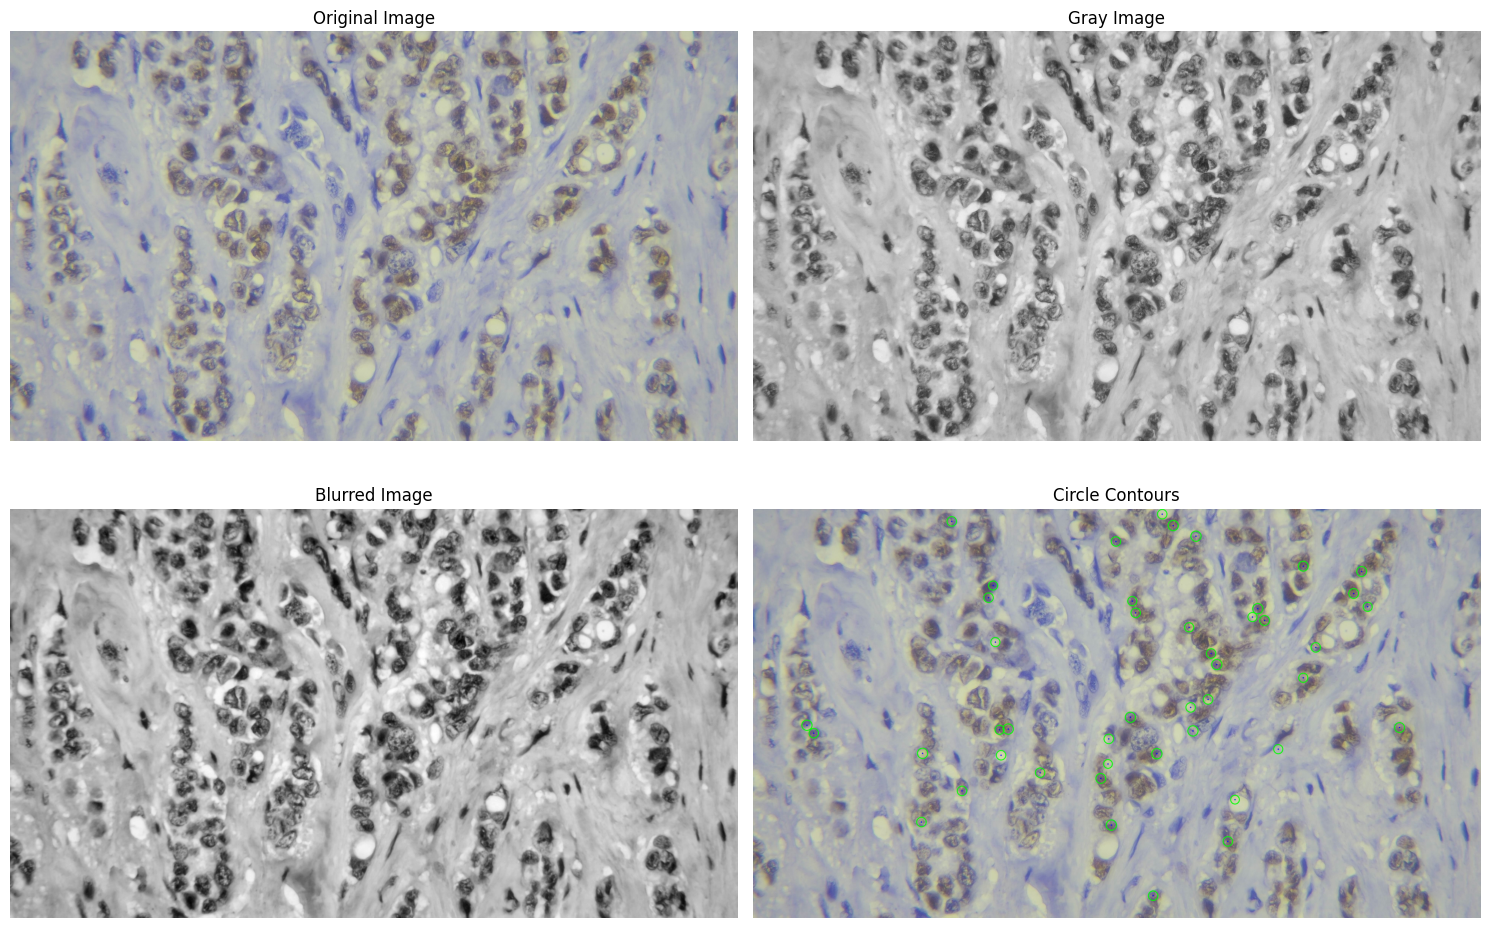

Number of circles: 45


In [55]:
import os

blur_kernel_size=(11,11)
dp=1
min_dist=45
param1=70
param2=11
min_radius=23
max_radius=28
show_img = True

def hough_iterator(path, number_of_samples):
  iteration = 0
  for filename in os.listdir(img_path):
    if filename.endswith('.jpg') and (iteration<number_of_samples):
        file_path = os.path.join(img_path, filename)
        print(f"Processing {file_path}")
        count = hough_circle_count(file_path, blur_kernel_size, dp, min_dist, param1, param2, min_radius, max_radius, show_img)
        print(f"Number of circles: {count}")
        iteration += 1

img_path = "/content/Foto Terklasifikasi/ER/Berdasarkan Pembesaran/400/"
hough_iterator(img_path, 1)

# 3. Watershed Algorithm

## Parameters
1. **kernel_size:** The size of the kernel used for morphological operations, specifically the cv2.morphologyEx function with the cv2.MORPH_OPEN operation. The kernel size affects how aggressively small noise is removed from the binary image. Larger kernels will remove more noise but may also remove smaller nuclei. Smaller kernels will retain more detail but may leave some noise.

Typical Range: (3, 3) to (7, 7). Start with smaller sizes and increase if necessary to handle larger noise or more detailed images.
2. **iterations_opening:** The number of iterations for the morphological opening operation, which removes small noise. More iterations will result in more aggressive noise removal, which can help in removing small irrelevant details but may also affect smaller nuclei. Fewer iterations will retain more detail but might leave noise.

Typical Range: 1 to 5. For cell nuclei counting, start with 2 and adjust based on the amount of noise and detail in your images.
3. **iterations_dilation:** The number of iterations for the dilation operation, which is used to expand the sure background area. More iterations will increase the sure background area, which helps in separating the nuclei from the background. However, too many iterations can cause overlap between nuclei.

Typical Range: 1 to 5. Start with 3 and adjust based on the spacing between nuclei and the image characteristics.
4. **dist_transform_mask_size:** The size of the mask used for the distance transform operation. A larger mask size provides more accurate distance measurements but may be computationally intensive. Smaller sizes can be faster but less accurate. It affects the detection of foreground areas.

Typical Range: 3 to 7. For detailed images, start with 5 and adjust based on the size of the nuclei.
5. **dist_transform_threshold:** The threshold value used to segment the distance transform into foreground regions.This parameter determines the cutoff for defining which regions are considered foreground. Lower values will include more of the distance transform as foreground, which may lead to over-segmentation. Higher values may miss some nuclei.

Typical Range: 0.5 to 0.8. Start with 0.7 and adjust based on the size and density of the nuclei.

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def watershed_detection(img_path, kernel_size=(3, 3), iterations_opening=2, iterations_dilation=3, dist_transform_mask_size=5, dist_transform_threshold=0.7, show_img=False):
  image = cv2.imread(img_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply Otsu's thresholding
  _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Remove small noise with morphological operations
  kernel = np.ones(kernel_size, np.uint8)
  opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=iterations_opening)

  # Sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations=iterations_dilation)

  # Finding sure foreground area using distance transform and thresholding
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, dist_transform_mask_size)
  _, sure_fg = cv2.threshold(dist_transform, dist_transform_threshold * dist_transform.max(), 255, 0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg, sure_fg)

  # Marker labelling
  _, markers = cv2.connectedComponents(sure_fg)

  # Add one to all labels so that sure background is not 0, but 1
  markers = markers + 1

  # Mark the region of unknown with zero
  markers[unknown == 255] = 0

  # Apply the Watershed algorithm
  markers = cv2.watershed(image, markers)
  image[markers == -1] = [255, 0, 0]  # Mark the boundaries with red color

  if show_img:
    # Plot original image, binary image, and markers overlaid on the original image in one subplot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(binary, cmap='gray')
    axs[1].set_title('Binary Image')
    axs[1].axis('off')

    # Create a color map with a single color for markers
    marker_color = [0, 255, 0]  # Green color for all markers
    color_map = np.zeros_like(image)
    color_map[markers > 1] = marker_color

    # Convert the color_map from BGR to RGB (for Matplotlib)
    rgb_color_map = cv2.cvtColor(color_map, cv2.COLOR_BGR2RGB)

    # Combine the color map with the original image
    overlay = cv2.addWeighted(image, 0.7, rgb_color_map, 0.3, 0)

    axs[2].imshow(overlay)
    axs[2].set_title('Markers Overlaid')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()

  return np.max(markers) - 1

Processing /content/Foto Terklasifikasi/ER/Berdasarkan Pembesaran/400/15. ER 400x positif.jpg


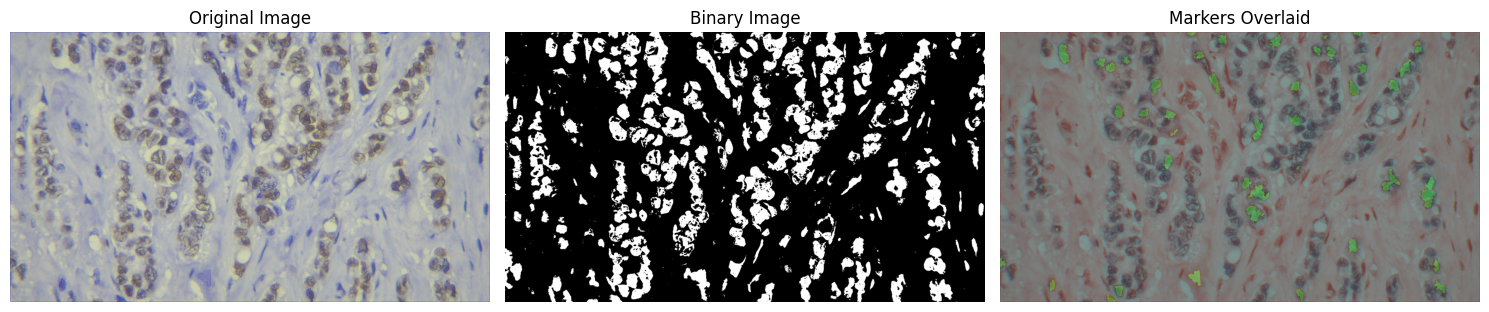

Number of circles: 55


In [44]:
import os

kernel_size=(3, 3)
iterations_opening=2
iterations_dilation=3
dist_transform_mask_size=5
dist_transform_threshold=0.7
show_img=True

def watershed_iterator(path, number_of_samples):
  iteration = 0
  for filename in os.listdir(img_path):
    if filename.endswith('.jpg') and (iteration<number_of_samples):
        file_path = os.path.join(img_path, filename)
        print(f"Processing {file_path}")
        count = watershed_detection(file_path, kernel_size, iterations_opening, iterations_dilation, dist_transform_mask_size, dist_transform_threshold, show_img)
        print(f"Number of circles: {count}")
        iteration += 1

img_path = "/content/Foto Terklasifikasi/ER/Berdasarkan Pembesaran/400/"
watershed_iterator(img_path, 1)